# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [3]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster
import joblib

In [4]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
# from pythoneeg import constants
# from pythoneeg.core.utils import compute_pac_spectrum
# from pythoneeg.pac.utils.pac import compute_pac_spectrum

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

core.set_temp_directory('/scr1/users/dongjp')

/home/dongjp/source-code/PyEEG
['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_path_to_genotype', 'parse_path_to_animal', 'parse_path_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [5]:
# cluster_spike = SLURMCluster(
#         cores=1,
#         memory='10GB',
#         processes=1,
#         walltime='12:00:00',
#         interface=None,
#         scheduler_options={'interface': 'eth1'},
#         job_extra_directives=['--output=/dev/null',
#                              '--error=/dev/null']
#     )
# cluster_spike.scale(10)
# display(cluster_spike)
# cluster_spike.wait_for_workers(10)

In [6]:
cluster_general = SLURMCluster(
        cores=8,
        memory='20GB',
        walltime='12:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'},
        job_extra_directives=['--output=/dev/null',
                             '--error=/dev/null']
    )
cluster_general.scale(jobs=10)
display(cluster_general)
cluster_general.wait_for_workers(10)

Dashboard: http://172.16.7.147:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.7.147:36421,Workers: 0
Dashboard: http://172.16.7.147:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [8]:
logger.setLevel(logging.DEBUG)

In [9]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...


    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-04-04 13:37:17,631 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-04-04 13:37:17,632 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


In [10]:
logger.setLevel(logging.WARNING)

Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


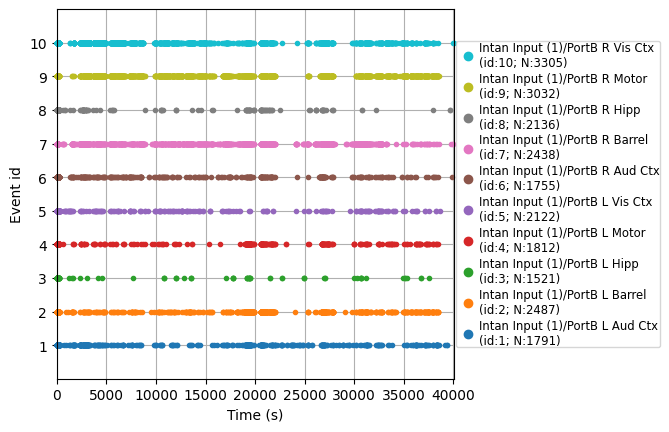

In [11]:
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)

In [12]:
def random_subsample_epochs(epochs: mne.Epochs, max_epochs=1000):
    if len(epochs) > max_epochs:
        # Get random indices for subsampling
        indices = np.random.choice(len(epochs), size=max_epochs, replace=False)
        epochs = epochs[indices]
    return epochs

In [88]:
# quick hack to look at peri-spike EEG

def analyze_peri_spike_tfr(mne_obj: mne.io.Raw, tmin=-10, tmax=5, tcrop=(-3, 3), baseline=(None, -5), l_freq=1, h_freq=50):
    """
    Analyze time-frequency representation around spikes from an MNE object.
    
    Parameters:
    -----------
    mne_obj : mne.io.Raw
        The MNE object containing the data and spike annotations
    tmin : float
        Start time relative to spike (in seconds)
    tmax : float
        End time relative to spike (in seconds)
    tcrop : tuple
        Time range to crop the data (in seconds)
    baseline : tuple
        Time range to compute baseline (in seconds)
    l_freq : float
        Lower frequency bound for filtering
    h_freq : float
        Upper frequency bound for filtering
    """
    raw = mne_obj.copy()
    
    # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
    # raw.filter(l_freq=l_freq, h_freq=h_freq)

    events, event_dict = mne.events_from_annotations(raw=raw)
    logging.debug(f"Events: {events}")
    logging.debug(f"Event dict: {event_dict}")

    # Process each spike type separately
    for i, channel_name in enumerate(event_dict.keys()):
        if i in [0, 1]:
            continue
        logging.debug(f"Processing channel: {channel_name}")
        
        # Create spike-centered epochs
        epochs = mne.Epochs(
            raw,
            tmin=tmin,
            tmax=tmax,
            baseline=baseline,
            event_repeated='drop',
            # preload=True,
            event_id=channel_name,
        )
        epochs.drop_bad()
        epochs = random_subsample_epochs(epochs).load_data()
        epochs.crop(tmin=tcrop[0], tmax=tcrop[1])
        # with joblib.parallel_backend('dask', scheduler_host=cluster_general.scheduler_address):
        epochs.filter(l_freq=l_freq, h_freq=h_freq)
        
        # Plot the epochs
        epochs.plot_image([channel_name])

        return epochs, epochs.get_data([channel_name])

        # FIXME this part is a WIP
        # logging.info(f"Computing TFR: {channel_name}")
        # with joblib.parallel_config('dask', scheduler_host=cluster_general.scheduler_address):
        #     # epochs.tfr_stockwell(l_freq=l_freq, h_freq=h_freq)
        #     # tfr_spike = epochs.compute_tfr(freqs=(l_freq, h_freq), method='stockwell', average=True)
        #     tfr_spike = epochs.compute_tfr(freqs=np.arange(l_freq, h_freq, 1), n_cycles=np.arange(l_freq, h_freq, 1) * 2, method='multitaper', use_fft=True, average=True)
        #     # TODO take log?
        #     # TODO implement morlet over multitaper, it's cleaner. Follow documentation for exact
        
        # tfr_spike.plot()

        break


In [89]:
def plot_tfr_hilbert(epochs: mne.Epochs, freqs: list[float], bandwidth: float):
    data = np.empty((len(epochs), len(epochs.ch_names), freqs.size, epochs.times.size), dtype=complex)
    logging.info(f"data shape: {data.shape}")
    for idx, freq in enumerate(freqs):
        data[:, :, idx] = epochs.get_data()
        
    # TODO implement hilbert transform on narrowband filter

    # power = mne.time_frequency.EpochsTFRArray(epochs.info, data, epochs.times, freqs, method="hilbert")
    # power.average().plot(
    #     [0],
    #     baseline=(0.0, 0.1),
    #     mode="mean",
    #     vlim=(0, 0.1),
    #     axes=ax,
    #     show=False,

        

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, layout="constrained")
# bandwidths = [1.0, 2.0, 4.0]
# for bandwidth, ax in zip(bandwidths, axs):
#     data = np.zeros(
#         (len(epochs), len(ch_names), freqs.size, epochs.times.size), dtype=complex
#     )
#     for idx, freq in enumerate(freqs):
#         # Filter raw data and re-epoch to avoid the filter being longer than
#         # the epoch data for low frequencies and short epochs, such as here.
#         raw_filter = raw.copy()
#         # NOTE: The bandwidths of the filters are changed from their defaults
#         # to exaggerate differences. With the default transition bandwidths,
#         # these are all very similar because the filters are almost the same.
#         # In practice, using the default is usually a wise choice.
#         raw_filter.filter(
#             l_freq=freq - bandwidth / 2,
#             h_freq=freq + bandwidth / 2,
#             # no negative values for large bandwidth and low freq
#             l_trans_bandwidth=min([4 * bandwidth, freq - bandwidth]),
#             h_trans_bandwidth=4 * bandwidth,
#         )
#         raw_filter.apply_hilbert()
#         epochs_hilb = Epochs(
#             raw_filter, events, tmin=0, tmax=n_times / sfreq, baseline=(0, 0.1)
#         )
#         data[:, :, idx] = epochs_hilb.get_data()
#     power = EpochsTFRArray(epochs.info, data, epochs.times, freqs, method="hilbert")
#     power.average().plot(
#         [0],
#         baseline=(0.0, 0.1),
#         mode="mean",
#         vlim=(0, 0.1),
#         axes=ax,
#         show=False,
#         colorbar=False,
#     )
#     n_cycles = "scaled by freqs" if not isinstance(n_cycles, int) else n_cycles
#     ax.set_title(
#         "Sim: Using narrow bandpass filter Hilbert,\n"
#         f"bandwidth = {bandwidth}, "
#         f"transition bandwidth = {4 * bandwidth}"
#     )

In [90]:
logger.setLevel(logging.DEBUG)

Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]
2025-04-04 14:53:54,485 - DEBUG - Events: [[     121        0        5]
 [     125        0        4]
 [     139        0        5]
 ...
 [39959945        0        7]
 [39975664        0       10]
 [40050738        0       10]]
2025-04-04 14:53:54,487 - DEBUG - Event dict: {np.str_('Intan Input (1)/PortB L Aud Ctx'): 1, np.str_('Intan Input (1)/PortB L Barrel'): 2, np.str_('Intan Input (1)/PortB L Hipp'): 3, np.str_('Intan Input (1)/PortB L Motor'): 4, np.str_('Intan Input (1)/PortB L Vis Ctx'): 5, np.str_('Intan Input (1)/PortB R Aud

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    3.3s
[Parallel(n_job

Not setting metadata
1000 matching events found
No baseline correction applied
0 projection items activated
2025-04-04 14:54:50,459 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fb13a66e950>


/tmp/ipykernel_363163/1045508915.py:56: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image([channel_name])


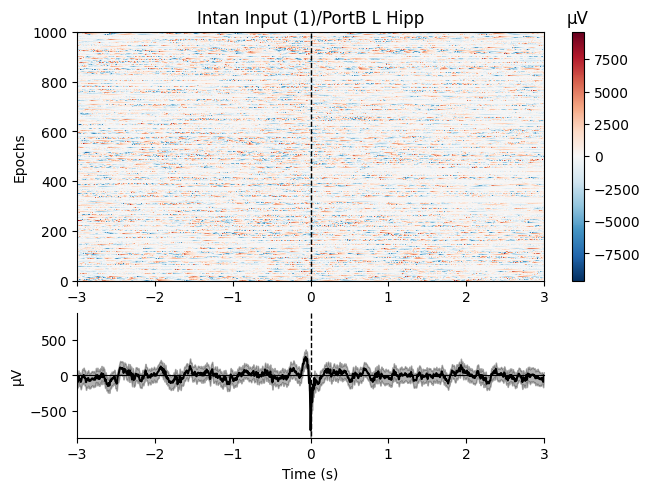

In [91]:
# display(mne_obj)
epochs = analyze_peri_spike_tfr(mne_obj)

## PAC

2025-04-04 14:54:52,090 - DEBUG - (1000, 3000)


2025-04-04 14:54:52,134 - DEBUG - (3000,)


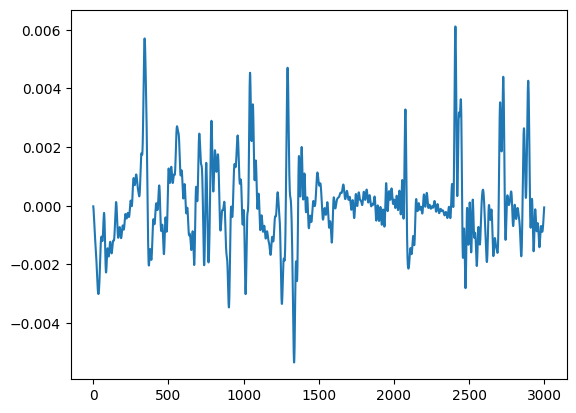

In [92]:
x = epochs[1]
x = x.reshape(x.shape[0], -1)
x_half = x[:, :x.shape[1] // 2]
logging.debug(x_half.shape)
x_test = x_half[61, :]

plt.plot(x_test)
logging.debug(x_test.shape)

In [93]:
# compute_pac_spectrum(x_test, np.arange(10, 50, 1), 1000, np.arange(0.1, 0.5, 0.1))
X = scipy.fft.fft(x_half, scipy.fft.next_fast_len(x_half.shape[-1]), axis=-1)
f = scipy.fft.fftfreq(scipy.fft.next_fast_len(x_half.shape[-1]), 1/1000)
X = X[:, :X.shape[1] // 2]
f = f[:f.shape[0] // 2]
logging.debug(f"f.shape, X.shape: {f.shape}, {X.shape}")

2025-04-04 14:54:52,338 - DEBUG - f.shape, X.shape: (1500,), (1000, 1500)


2025-04-04 14:54:52,362 - DEBUG - (1000,)
2025-04-04 14:54:52,364 - DEBUG - (1000, 6001)


2025-04-04 14:54:52,553 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fb13b0c42e0>


Text(0.5, 1.0, 'Sorted Trials Matrix')

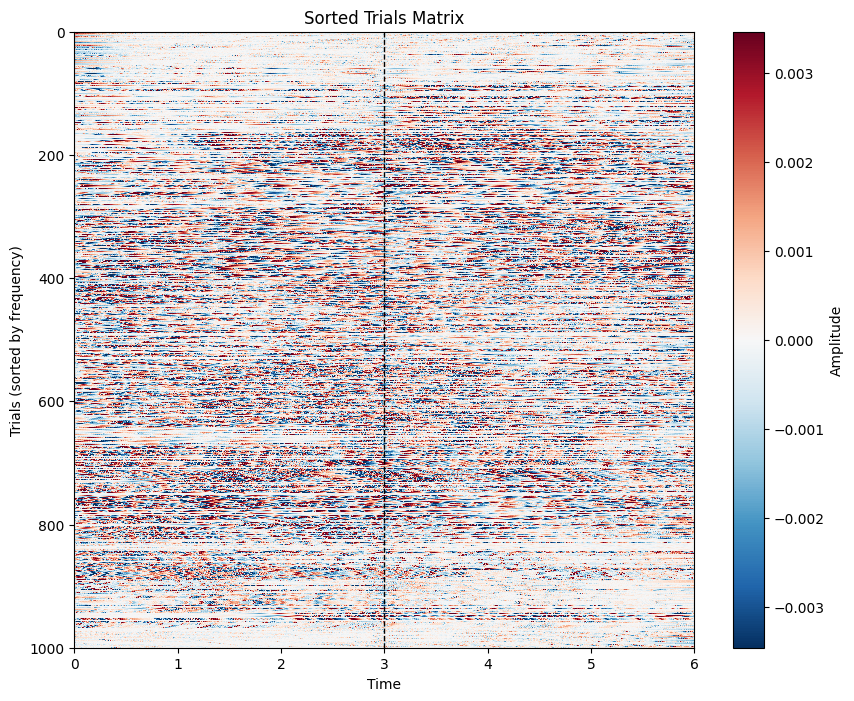

In [94]:
X_inds = np.argmax(np.abs(X), axis=-1).argsort()
logging.debug(X_inds.shape)
logging.debug(x.shape)
x_sorted = x[X_inds, :]
plt.figure(figsize=(10,8))
plt.imshow(x_sorted, aspect='auto', interpolation='nearest',
           extent=[0, x_sorted.shape[1] / 1000, x_sorted.shape[0], 0],
           cmap='RdBu_r', norm=plt.Normalize(vmin=-np.std(np.abs(x_sorted) * 3), 
                                           vmax=np.std(np.abs(x_sorted) * 3)))
plt.axvline(x=3, color='black', linestyle='--', linewidth=1)
plt.colorbar(label='Amplitude')
plt.xlabel('Time')
plt.ylabel('Trials (sorted by frequency)')
plt.title('Sorted Trials Matrix')

